In [1]:
import pandas as pd
import fbprophet
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
# usado para ver todas las columna 
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import plot_cross_validation_metric

%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

### Functions of general data cleaning

In [3]:
# Función para poner el estado en mayúsculas y quitar la clabe de dos letras.
def clean_state(state) :
    state = state.replace('-',' ').title()
    return state[:-3]

In [4]:
def salary_range(wage):
    if wage > 0 and wage <= 2000 :
        return '< $2k'
    elif wage >2000 and wage<=3000 :
        return '2k-$3k'
    elif wage >3000 and wage<=4000 :
        return '3k-$4k'
    elif wage >4000 and wage<=5000 :
        return '4k-$5k'
    elif wage >5000 and wage<=6000 :
        return '5k-$6k'
    elif wage >6000 and wage<=7000 :
        return '6k-$7k'
    elif wage >7000 and wage<=8000 :
        return '7k-$8k'
    elif wage >8000 and wage<=9000 :
        return '8k-$9k'
    elif wage >9000 and wage<=12000 :
        return '9k-$12k'
    elif wage >12000 :
        return '$12k +'

### Functions for FB prophet prediction model

Facebook Prophet is a dynamic time series forecasting tool which is available in Python. We build, apply and visualize a model with focus on the future behaviour of the average wage gap between men and women, based on the linechart on the PowerBI dashboard.

In [5]:
#Function for prediction
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of datapoints at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    df.dropna(inplace=True)
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [6]:
#Creating a function to automate the model process.

def prophet_model(df,predictions) :
    """Calculate the model FBProhpet prediction and the MAPE and MAE of the forecast.
    
       Args:
           df: data frame with date time 'ds' and data 'y'
           predictions: numbers of data points to be predicted, (quarterly anual data)
    """
    periods = [0, predictions]
    model = Prophet(yearly_seasonality = True, weekly_seasonality = False)
    model.fit(df)
    for number in periods :
        future = model.make_future_dataframe(periods= number, freq= '3MS')
        forecast = model.predict(future)
        #fig = plot_plotly(model, forecast)
        #fig.show()
        if number == 0 :
            df_error = df[['ds','y']].copy()
            df_error['yhat'] = forecast.yhat.values
            error = calculate_forecast_errors(df_error, len(df))
            print('Periods predicted: ', number, '\n')
            print(error)
    return (model, forecast, error)

In [7]:
def salary_gap(name,periods) :
    """ With the prediccion of two data sets calculate the differences of salaries.
    
       Args:
           list: list with the name of two data frames each one with date time 'ds' and data 'y'
           periods: numbers of data points to be predicted, (quarterly anual data)
    """
    model_female, forecast_female, error_female = prophet_model(name[0],periods)
    model_male, forecast_male, error_male = prophet_model(name[1],periods)
    dictionary = {'Date': forecast_female.ds, 'Salary Male': forecast_male.yhat, 'Salary Female': forecast_female.yhat, 'Wage Gap': (forecast_female.yhat-forecast_male.yhat)/forecast_male.yhat*100}
    gap = pd.DataFrame(dictionary)
    return (model_female, forecast_female, model_male, forecast_male, gap, error_female, error_male)
    

## General Data Cleaning for map visualization for Power Bi Dashboard

In [8]:
# Cargando los datos
enoe = pd.read_csv('./DataBasesUsed/ENOE2020Q4Q3.csv',  encoding = 'utf8')

In [9]:
#
#Limipiando la columna de State. Solo ejecutar esta celda una vez.
enoe.State = enoe.State.apply(clean_state)

In [10]:
# Asignado el intervalo de salario
enoe['Salary Group'] = enoe['Monthly Wage'].apply(salary_range)

In [11]:
enoe.head()

,Quarter ID,Quarter,Classification of Formal and Informal Jobs of the First Activity ID,Classification of Formal and Informal Jobs of the First Activity,Group ID,Group,Job Situation ID,Job Situation,Schooling Years Range ID,Schooling Years Range,Sex ID,Sex,State ID,State,Number of Records,Workforce,Monthly Wage,Salary Group
0,20101,2010-Q1,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1,Posee un Trabajo o Negocio,1,0 a 3 Años de Escolaridad,1,Hombre,10,Durango,1,62,0.0,None
1,20101,2010-Q1,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1,Posee un Trabajo o Negocio,1,0 a 3 Años de Escolaridad,1,Hombre,29,Tlaxcala,1,56,2580.0,2k-$3k
2,20101,2010-Q1,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1,Posee un Trabajo o Negocio,2,4 a 6 Años de Escolaridad,1,Hombre,6,Colima,1,92,540.0,< $2k
3,20101,2010-Q1,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1,Posee un Trabajo o Negocio,2,4 a 6 Años de Escolaridad,1,Hombre,7,Chiapas,1,72,15480.0,$12k +
4,20101,2010-Q1,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1,Posee un Trabajo o Negocio,2,4 a 6 Años de Escolaridad,1,Hombre,30,Veracruz De Ignacio De La Llave,1,1214,12000.0,9k-$12k


In [12]:
name_columns = enoe.columns.to_list()
name_columns.remove('Number of Records')
name_columns

['Quarter ID',
 'Quarter',
 'Classification of Formal and Informal Jobs of the First Activity ID',
 'Classification of Formal and Informal Jobs of the First Activity',
 'Group ID',
 'Group',
 'Job Situation ID',
 'Job Situation',
 'Schooling Years Range ID',
 'Schooling Years Range',
 'Sex ID',
 'Sex',
 'State ID',
 'State',
 'Workforce',
 'Monthly Wage',
 'Salary Group']

In [13]:
enoe[enoe['Quarter']=='2020-Q4']['Workforce'].sum()

1396576

In [14]:
# Delete number register column
enoe = enoe[name_columns]

In [15]:
# File csv to map wage gap in power bi
enoe.to_csv('./DataBaseBI/enoe_map_bi.csv', index = False)

## General Data Cleaning for wage gap with segregated instruction level visualization in Power Bi Dashboard

In [16]:
enoe_instruction = pd.read_csv('./DataBasesUsed/Instruction_Level_ENOE.csv', encoding = 'utf8')

In [17]:
enoe_instruction.shape

(45983, 12)

In [18]:
enoe_instruction.tail(100)

,Sex ID,Sex,Quarter ID,Quarter,Instruction Level ID,Instruction Level,Classification of Formal and Informal Jobs of the First Activity ID,Classification of Formal and Informal Jobs of the First Activity,Group ID,Group,Workforce,Monthly Wage
45883,2,Mujer,20204,2020-Q4,8,Maestría,1,Empleo Informal,11,Funcionarios y Altas Autoridades de los Sector...,770,6087.012987
45884,2,Mujer,20204,2020-Q4,8,Maestría,1,Empleo Informal,12,Directores y Gerentes en Servicios Financieros...,875,4651.428571
45885,2,Mujer,20204,2020-Q4,8,Maestría,1,Empleo Informal,13,"Directores y Gerentes en Producción, Tecnologí...",42,0.000000
45886,2,Mujer,20204,2020-Q4,8,Maestría,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1136,0.000000
45887,2,Mujer,20204,2020-Q4,8,Maestría,1,Empleo Informal,15,Coordinadores y Jefes de Área en Servicios Fin...,2049,9291.361640
...,...,...,...,...,...,...,...,...,...,...,...,...
45978,2,Mujer,20204,2020-Q4,99,No Sabe Nivel,2,Empleo Formal,53,Trabajadores en Servicios de Protección y Vigi...,58,0.000000
45979,2,Mujer,20204,2020-Q4,99,No Sabe Nivel,2,Empleo Formal,81,Operadores de Instalaciones y Maquinaria Indus...,359,0.000000
45980,2,Mujer,20204,2020-Q4,99,No Sabe Nivel,2,Empleo Formal,82,"Ensambladores y Montadores de Herramientas, Ma...",186,0.000000
45981,2,Mujer,20204,2020-Q4,99,No Sabe Nivel,2,Empleo Formal,92,"Trabajadores de Apoyo en la Minería, Construcc...",300,7740.000000


In [19]:
#Generating the salary group 
#Generando el Grupo de salario
enoe_instruction['Salary Group'] = enoe_instruction['Monthly Wage'].apply(salary_range)

In [20]:
enoe_instruction.to_csv('./DataBaseBI/enoe_salary_instructionlevel.csv',index= False)

In [21]:
enoe_instruction['Salary Group'].isnull().sum()

3587

## Data preparation for FB prophet model

In [22]:
#  Number of rows with Monthly wage reported as 0.
len(enoe_instruction[enoe_instruction['Monthly Wage'] == 0]),len(enoe_instruction)

(3587, 45983)

In [23]:
# Percentage of workforce with Monthly wage reported as 0.
print('El porcentaje de los datos que tiene 0 en el salario  es ',len(enoe_instruction[enoe_instruction['Monthly Wage'] == 0])/len(enoe_instruction) * 100, '%' )

El porcentaje de los datos que tiene 0 en el salario  es  7.800708957658264 %


In [24]:
#The zero Monthly Wage represented 0.10% of the workforce
enoe_instruction[enoe_instruction['Monthly Wage'] == 0]['Workforce'].sum()/enoe_instruction['Workforce'].sum()*100

0.10467216752340223

In [25]:
# Drop rows with zero Monthly wage, because we will use an weighted average
enoe_salary = enoe_instruction.drop(enoe_instruction.loc[enoe_instruction['Monthly Wage'] == 0].index)

In [26]:
enoe_salary.head()

,Sex ID,Sex,Quarter ID,Quarter,Instruction Level ID,Instruction Level,Classification of Formal and Informal Jobs of the First Activity ID,Classification of Formal and Informal Jobs of the First Activity,Group ID,Group,Workforce,Monthly Wage,Salary Group
0,1,Hombre,20101,2010-Q1,0,Ninguno,1,Empleo Informal,14,"Directores y Gerentes de Ventas, Restaurantes,...",1092,2976.362637,2k-$3k
2,1,Hombre,20101,2010-Q1,0,Ninguno,1,Empleo Informal,41,Comerciantes en Establecimientos,562,2896.708185,2k-$3k
3,1,Hombre,20101,2010-Q1,0,Ninguno,1,Empleo Informal,52,Trabajadores en Cuidados Personales y del Hogar,32421,1949.381296,< $2k
4,1,Hombre,20101,2010-Q1,0,Ninguno,1,Empleo Informal,54,Trabajadores de las Fuerzas Armadas,2338,1235.658683,< $2k
5,1,Hombre,20101,2010-Q1,0,Ninguno,1,Empleo Informal,62,"Trabajadores en Actividades Pesqueras, Foresta...",332,1032.000000,< $2k


In [27]:
enoe_salary.shape

(42396, 13)

In [28]:
#Function defines to get the weighted average using the workforce and monthly wage
weighted_average = lambda x: np.average(x, weights = enoe_salary.loc[x.index , 'Workforce'])

In [29]:
#Create a gender dataframes with average salary by quarter
salary_female = enoe_salary[enoe_salary['Sex'] == 'Mujer'].groupby('Quarter')['Monthly Wage'].agg(weighted_average)
salary_male = enoe_salary[enoe_salary['Sex'] == 'Hombre'].groupby('Quarter')['Monthly Wage'].agg(weighted_average)
salary_female = salary_female.to_frame().reset_index()
salary_male = salary_male.to_frame().reset_index()
salary_female.columns = ['Quarter','Monthly Wage']
salary_male.columns = ['Quarter','Monthly Wage']

In [30]:
salary_male

,Quarter,Monthly Wage
0,2010-Q1,4497.099017
1,2010-Q2,4504.512960
2,2010-Q3,4318.655958
3,2010-Q4,4169.401030
4,2011-Q1,4277.819376
5,2011-Q2,4120.119249
6,2011-Q3,4279.173757
7,2011-Q4,4024.623105
8,2012-Q1,4300.954612
9,2012-Q2,4397.125023


In [31]:
#Create a table for a difference salary visualization
dictionary = {'Trimestre':salary_female['Quarter'], 'Mujer' : salary_female['Monthly Wage'],'Hombre' : salary_male['Monthly Wage']}
salary = pd.DataFrame(dictionary)
salary

,Trimestre,Mujer,Hombre
0,2010-Q1,2461.631872,4497.099017
1,2010-Q2,2488.314399,4504.512960
2,2010-Q3,2525.504047,4318.655958
3,2010-Q4,2473.760762,4169.401030
4,2011-Q1,2576.878987,4277.819376
5,2011-Q2,2505.536694,4120.119249
6,2011-Q3,2507.493342,4279.173757
7,2011-Q4,2370.823191,4024.623105
8,2012-Q1,2578.617045,4300.954612
9,2012-Q2,2572.478058,4397.125023


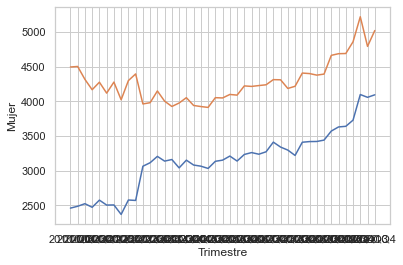

In [32]:
sns.set_theme(style = 'whitegrid')
ax = sns.lineplot(data = salary, x = 'Trimestre', y = 'Mujer' )
ax = sns.lineplot(data = salary, x = 'Trimestre', y = 'Hombre' )

In [33]:
#Generate cvs files for prediction model
salary_male.to_csv('./Estimations/df_salary_male.csv', index = False)
salary_female.to_csv('./Estimations/df_salary_female.csv', index = False)

In [34]:
#Make de model prediction . 
salary_male.columns = ['ds', 'y']
salary_female.columns = ['ds', 'y']
salary_female['ds'] = pd.to_datetime(salary_female.ds)
salary_male['ds'] = pd.to_datetime(salary_male.ds)


In [35]:
model_female, forecast_female, model_male, forecast_male, gap_national, error_female, error_male = salary_gap([salary_female, salary_male],100)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 2.316773971240189, 'MAE': 70.77406697223861}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.2625377048291908, 'MAE': 54.80194660170251}


In [36]:
gap_national['Group']= 'Nacional'
gap_national['Salary Female Data'] = salary_female.y
gap_national['Salary Male Data'] = salary_male.y
gap_national

,Date,Salary Male,Salary Female,Wage Gap,Group,Salary Female Data,Salary Male Data
0,2010-01-01,4441.787791,2460.460907,-44.606518,Nacional,2461.631872,4497.099017
1,2010-04-01,4371.878224,2460.914460,-43.710361,Nacional,2488.314399,4504.512960
2,2010-07-01,4281.326320,2465.432849,-42.414274,Nacional,2525.504047,4318.655958
3,2010-10-01,4210.647091,2435.088034,-42.168318,Nacional,2473.760762,4169.401030
4,2011-01-01,4350.288783,2585.993953,-40.555809,Nacional,2576.878987,4277.819376
...,...,...,...,...,...,...,...
138,2044-10-01,11254.458795,9598.858737,-14.710615,Nacional,NaN,NaN
139,2045-01-01,11444.457700,9754.782840,-14.764132,Nacional,NaN,NaN
140,2045-04-01,11480.549197,9653.464094,-15.914614,Nacional,NaN,NaN
141,2045-07-01,11389.678350,9733.021453,-14.545247,Nacional,NaN,NaN


In [37]:
error_national = { 'MAPE': [error_female['MAPE'],error_male['MAPE']], 'MAE': [error_female['MAE'],error_male['MAE']], 'Group':['National','National'], 'Gender':['Mujer','Hombre'] }
error_national = pd.DataFrame(error_national)

## Model prediction with FBProphet

## Data frame creation for calculation of wage gap for different ocupation groups


In [38]:
enoe_salary.Group.unique()

array(['Directores y Gerentes de Ventas, Restaurantes, Hoteles y otros Establecimientos',
       'Comerciantes en Establecimientos',
       'Trabajadores en Cuidados Personales y del Hogar',
       'Trabajadores de las Fuerzas Armadas',
       'Trabajadores en Actividades Pesqueras, Forestales, Caza y Similares',
       'Trabajadores en la Extracción y la Edificación de Construcciones',
       'Artesanos y Trabajadores en el Tratamiento y Elaboración de Productos de Metal',
       'Operadores de Instalaciones y Maquinaria Industrial',
       'Conductores de Transporte y de Maquinaria Móvil',
       'Directores y Gerentes en Servicios Financieros, Administrativos y Sociales',
       'Especialistas en Ciencias Económico-Administrativas, Ciencias Sociales, Humanistas y en Artes',
       'Trabajadores en la Preparación y Servicio de Alimentos y Bebidas en Establecimientos',
       'Trabajadores en Servicios de Protección y Vigilancia',
       'Trabajadores en Actividades Agrícolas y Ganade

In [39]:
# Top 5 occupations of women in Mexico with mayor workforce in 2020 Q4, based on Power BI visualization
top5_groups = ['Empleados de Ventas en Establecimientos', 'Trabajadores Domésticos, de Limpieza, Planchadores y otros Trabajadores de Limpieza', 'Secretarias, Capturistas, Cajeros y Trabajadores de Control de Archivo y Transporte', 'Comerciantes en Establecimientos', 'Trabajadores en la Preparación y Servicio de Alimentos y Bebidas en Establecimientos' ]
top5_titulo = ['ventas','limpieza','secretariado','comercio','alimentos']

In [40]:
# Generate dataframe with female and male salary for each ocupation group in the top 5. 
tablas_salary = dict()
for i, group in enumerate(top5_groups) :
    sector = enoe_salary[enoe_salary.Group == group]
    sector_female = sector[sector['Sex'] == 'Mujer'].groupby('Quarter')['Monthly Wage'].agg(weighted_average).to_frame().reset_index()
    sector_female.columns = ['ds','y']
    sector_male = sector[sector['Sex'] == 'Hombre'].groupby('Quarter')['Monthly Wage'].agg(weighted_average).to_frame().reset_index()
    sector_male.columns = ['ds','y']
    sector_female['ds'] = pd.to_datetime(sector_female.ds)
    sector_male['ds'] = pd.to_datetime(sector_male.ds)
    tablas_salary[top5_titulo[i]] = [sector_female, sector_male]
    

In [ ]:
tablas_salary['ventas'][1]

In [41]:
## Apply FB Prophet model to each data frame and compare the result. Save the prediction results in general table
#top5_titulo = ['ventas','limpieza','secretariado','comercio','alimentos']
prediction_points = [100,100,100,100, 100]
gap_group = pd.DataFrame( )
error_prediction = pd.DataFrame()
for i, group in enumerate(top5_titulo) :
    model_female, forecast_female, model_male, forecast_male, gap, error_female, error_male = salary_gap([tablas_salary[group][0], tablas_salary[group][1]],prediction_points[i])
    gap['Group']= top5_groups[i]
    gap['Salary Female Data'] = tablas_salary[group][0].y
    gap['Salary Male Data'] = tablas_salary[group][1].y
    gap_group = pd.concat([gap_group,gap])
    error_dict = { 'MAPE': [error_female['MAPE'],error_male['MAPE']], 'MAE': [error_female['MAE'],error_male['MAE']], 'Group':[top5_groups[i],top5_groups[i]], 'Gender':['Mujer','Hombre'] }
    error_model = pd.DataFrame(error_dict)
    error_prediction = pd.concat([ error_prediction , error_model])
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.4643329124382276, 'MAE': 35.2350018926081}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 2.06294588894142, 'MAE': 77.7695469152288}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 0.8162456280024276, 'MAE': 22.735407287445263}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.4295621166095882, 'MAE': 50.93197776403811}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.6693620047295192, 'MAE': 68.1585536868176}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

In [42]:
error_prediction = pd.concat([error_national,error_prediction])

In [43]:
#Print the MAPE and MAE ofr the prediction FB Model.
error_prediction

,MAPE,MAE,Group,Gender
0,2.316774,70.774067,National,Mujer
1,1.262538,54.801947,National,Hombre
0,1.464333,35.235002,Empleados de Ventas en Establecimientos,Mujer
1,2.062946,77.769547,Empleados de Ventas en Establecimientos,Hombre
0,0.816246,22.735407,"Trabajadores Domésticos, de Limpieza, Planchad...",Mujer
1,1.429562,50.931978,"Trabajadores Domésticos, de Limpieza, Planchad...",Hombre
0,1.669362,68.158554,"Secretarias, Capturistas, Cajeros y Trabajador...",Mujer
1,2.074877,92.397017,"Secretarias, Capturistas, Cajeros y Trabajador...",Hombre
0,19.758461,303.990113,Comerciantes en Establecimientos,Mujer
1,7.628521,283.390313,Comerciantes en Establecimientos,Hombre


In [44]:
gap_group = pd.concat([gap_national,gap_group])

In [45]:
top5_groups_error = ['Empleados de Ventas en Establecimientos', 'Trabajadores Domésticos, de Limpieza, Planchadores y otros Trabajadores de Limpieza', 'Secretarias, Capturistas, Cajeros y Trabajadores de Control de Archivo y Transporte']
top5_titulo_error = ['ventas','limpieza','secretariado']

In [46]:
#Repeat the estimation for the selected groups
prediction_points = [120,100,20]
gap_group = pd.DataFrame( )
error_prediction = pd.DataFrame()
for i, group in enumerate(top5_titulo_error) :
    model_female, forecast_female, model_male, forecast_male, gap, error_female, error_male = salary_gap([tablas_salary[group][0], tablas_salary[group][1]],prediction_points[i])
    gap['Group']= top5_groups_error[i]
    gap['Salary Female Data'] = tablas_salary[group][0].y
    gap['Salary Male Data'] = tablas_salary[group][1].y
    gap_group = pd.concat([gap_group,gap])
    error_dict = { 'MAPE': [error_female['MAPE'],error_male['MAPE']], 'MAE': [error_female['MAE'],error_male['MAE']], 'Group':[top5_groups_error[i],top5_groups_error[i]], 'Gender':['Mujer','Hombre'] }
    error_model = pd.DataFrame(error_dict)
    error_prediction = pd.concat([ error_prediction , error_model])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.4643329124382276, 'MAE': 35.2350018926081}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 2.06294588894142, 'MAE': 77.7695469152288}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 0.8162456280024276, 'MAE': 22.735407287445263}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.4295621166095882, 'MAE': 50.93197776403811}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Periods predicted:  0 

{'MAPE': 1.6693620047295192, 'MAE': 68.1585536868176}
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override thi

In [47]:
error_prediction2 = pd.concat([error_national,error_prediction])

In [48]:
error_prediction2

,MAPE,MAE,Group,Gender
0,2.316774,70.774067,National,Mujer
1,1.262538,54.801947,National,Hombre
0,1.464333,35.235002,Empleados de Ventas en Establecimientos,Mujer
1,2.062946,77.769547,Empleados de Ventas en Establecimientos,Hombre
0,0.816246,22.735407,"Trabajadores Domésticos, de Limpieza, Planchad...",Mujer
1,1.429562,50.931978,"Trabajadores Domésticos, de Limpieza, Planchad...",Hombre
0,1.669362,68.158554,"Secretarias, Capturistas, Cajeros y Trabajador...",Mujer
1,2.074877,92.397017,"Secretarias, Capturistas, Cajeros y Trabajador...",Hombre


In [49]:
gap_group_final = pd.concat([gap_national,gap_group])

In [50]:
gap_group_final.Group.unique()

array(['Nacional', 'Empleados de Ventas en Establecimientos',
       'Trabajadores Domésticos, de Limpieza, Planchadores y otros Trabajadores de Limpieza',
       'Secretarias, Capturistas, Cajeros y Trabajadores de Control de Archivo y Transporte'],
      dtype=object)

In [51]:
#Create csv file for estimation visualization in Power Bi Dashboard
gap_group_final.to_csv('./DataBaseBI/salary_gap_group.csv',index=False)

## Sources

https://www.youtube.com/watch?v=eq7_3HA7QQI

https://facebook.github.io/prophet/docs/diagnostics.html

https://digitaltesseract.com/facebook-prophet-to-forecast-minimum-temperature/